In [26]:
import pandas as pd
import shap

In [27]:
df = pd.read_csv("../data/dataproject2025_preprocessed_combined.csv")
df.head()

,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__emp_length,num__fico_range_high,num__funded_amnt,num__inq_last_6mths,...,label__emp_title,label__home_ownership,label__purpose,ord__grade,ord__sub_grade,passthrough__issue_d,passthrough__zip_code,passthrough__Pct_afro_american,Predicted probabilities,target
0,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,-1.076012,2.106130,-1.180039,1.439967,...,33.0,0.0,3.0,1.0,6.0,2013.0,782.0,7.388592,0.053051,0
1,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.083330,1.258044,1.180387,-0.694720,...,33.0,1.0,2.0,1.0,6.0,2013.0,481.0,9.745456,0.084507,0
2,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,-0.266259,1.766896,1.281169,0.372623,...,41.0,0.0,2.0,0.0,2.0,2013.0,945.0,7.542862,0.037206,0
3,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,1.083330,0.749193,-0.416216,0.372623,...,33.0,0.0,2.0,1.0,7.0,2013.0,809.0,6.598132,0.061371,0
4,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,0.003659,-0.946979,1.238734,0.372623,...,33.0,0.0,2.0,3.0,19.0,2013.0,802.0,7.058900,0.345896,1


In [28]:
X = df.drop(columns=["target", "Predicted probabilities"])
y = df["target"]

# To be deleted:

In [29]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    verbose=0,  # no training logs
    random_seed=42,  # reproducibility
    eval_metric="Logloss",
)

model.fit(X, y)

In [30]:
"""import pickle
from catboost import CatBoostClassifier

# Load the trained CatBoost model
with open("../models/catboost_timeordinal.pkl", "rb") as f:
    model = pickle.load(f)"""

'import pickle\nfrom catboost import CatBoostClassifier\n\n# Load the trained CatBoost model\nwith open("../models/catboost_timeordinal.pkl", "rb") as f:\n    model = pickle.load(f)'

## SHAP Feature Importance

In [31]:
from catboost import Pool

# Create CatBoost Pool
pool = Pool(data=X, label=y)

# Get SHAP values (last column = base value)
shap_values = model.get_feature_importance(type="ShapValues", data=pool)

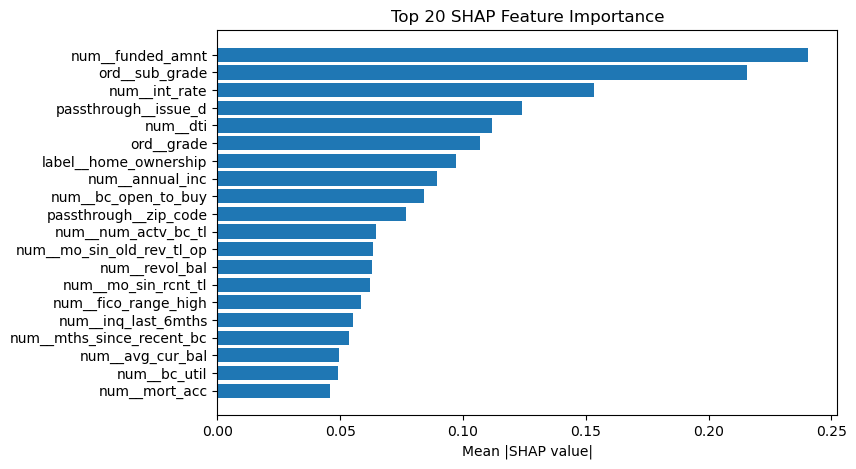

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Compute mean |SHAP| importance
feature_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Keep only top 20
top_n = 20
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_idx], feature_importance[top_idx])
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {top_n} SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## SHAP Force Plot

In [33]:
shap.initjs()

# Pick one observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Extract SHAP values and base value for this observation
single_shap_values = shap_values[index_to_explain, :-1]
base_value = shap_values[index_to_explain, -1]

# Interactive force plot
shap.force_plot(base_value, single_shap_values, single_X)

In [34]:
# Create force plot
force_plot = shap.force_plot(base_value, single_shap_values, single_X)

# Save to HTML
shap.save_html("force_plot.html", force_plot)
print("Force plot saved as force_plot.html")

Force plot saved as force_plot.html


## SHAP Waterfall Plot

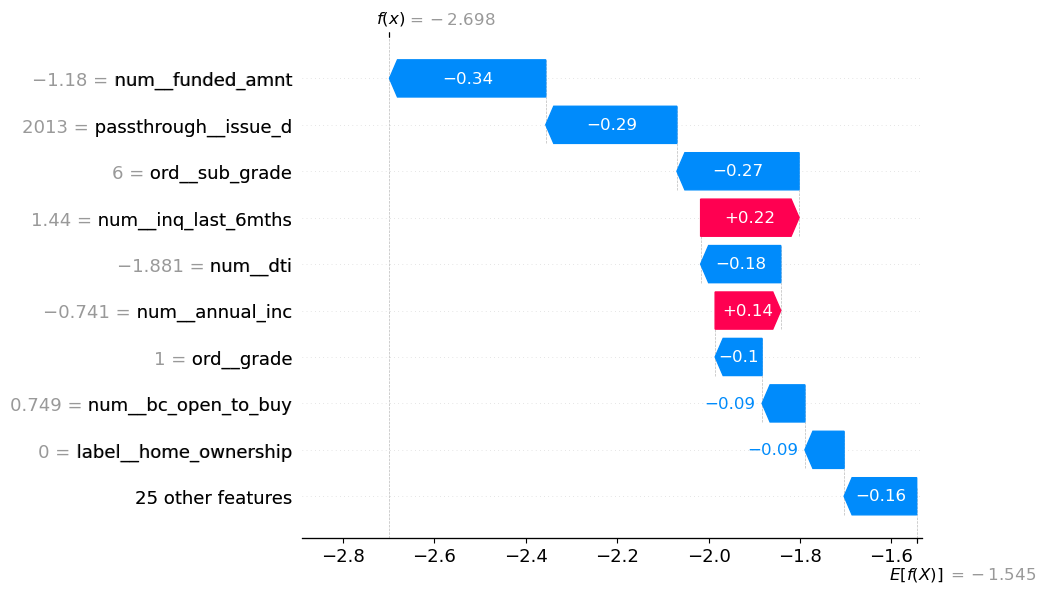

In [35]:
# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=single_shap_values,
        base_values=base_value,
        data=single_X.values[0],
        feature_names=single_X.columns.tolist(),
    )
)

## SHAP Summary Plot

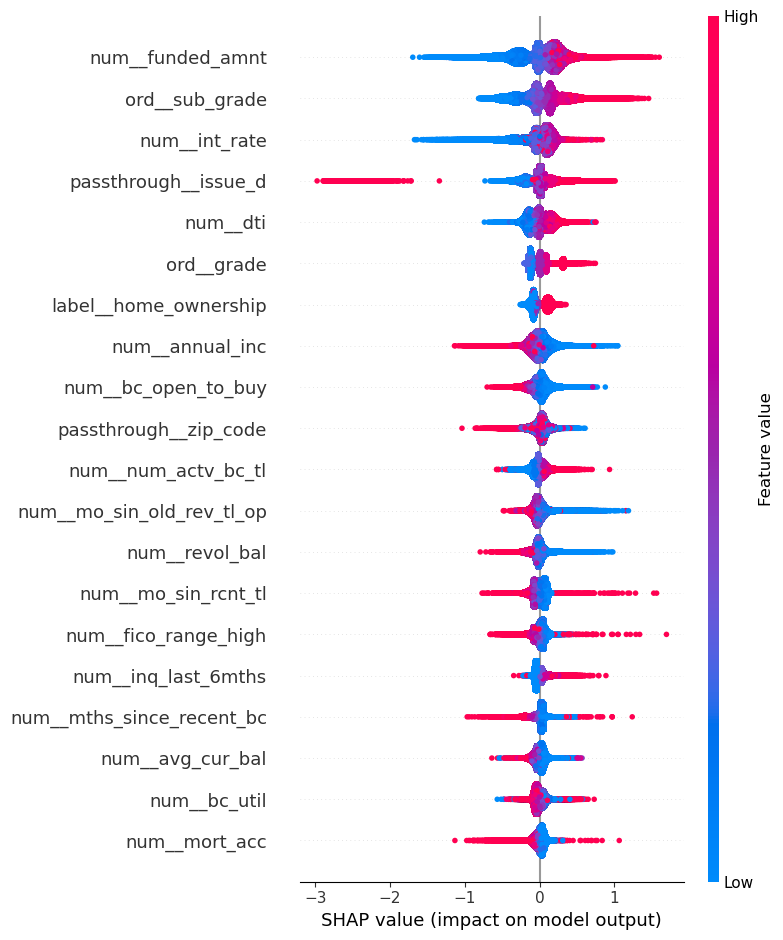

In [36]:
# SHAP summary plot
shap.summary_plot(shap_values[:, :-1], X)